In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_selector as selector

# 업샘플링에 사용되는 라이브러리
from imblearn.over_sampling import ADASYN

data = pd.read_csv('사용할 데이터.csv',index_col=0)

In [2]:
data.shape

(3735596, 7)

In [3]:
dt = data.copy()
dt['역전세 위험'] = dt['전세가율']*0
dt.loc[(dt['전세가율'] > 70)&(dt['전세가 변화율'] < 0),'역전세 위험']=1

In [4]:
#자치구명 법정동

In [5]:
dt['자치구'] = dt['건물'].str.split().str[0]
dt['법정동'] = dt['건물'].str.split().str[1]
dt['면적(㎡)'] = dt['건물'].str.split().str[5]
dt['2층'] = dt['건물'].str.split().str[7]

In [6]:
df = dt.copy()

df.drop(columns = ['건물','전세가율','전세가 변화율'],inplace = True)

cols = df.columns.tolist()
cols = cols[-4:] + cols[:-4]
df = df[cols]

df

,자치구,법정동,면적(㎡),2층,계약월,월별평균 매매가,월별평균 전세가,매매가 변화율,역전세 위험
0,강남구,개포동,74㎡,이하,2017-07,55400.000000,25563.030208,0.000000,0.0
1,강남구,개포동,74㎡,이하,2017-08,55865.129446,25714.518156,0.000000,0.0
2,강남구,개포동,74㎡,이하,2017-09,55768.618437,25748.462678,0.000000,0.0
3,강남구,개포동,74㎡,이하,2017-10,55962.980886,25771.746937,0.000000,0.0
4,강남구,개포동,74㎡,이하,2017-11,56373.822889,25866.286638,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
3735591,중랑구,중화동,96㎡,초과,2023-03,83658.567397,45000.000000,-0.067474,0.0
3735592,중랑구,중화동,96㎡,초과,2023-04,83239.667064,44676.854996,-0.075041,0.0
3735593,중랑구,중화동,96㎡,초과,2023-05,82999.388734,44480.292271,-0.079964,0.0
3735594,중랑구,중화동,96㎡,초과,2023-06,82954.053200,44426.263250,-0.085110,0.0


In [7]:
df['역전세 위험'].value_counts(normalize=True)

역전세 위험
0.0    0.947655
1.0    0.052345
Name: proportion, dtype: float64

In [8]:
X = df.drop(columns=['역전세 위험'])
y = df['역전세 위험']

In [9]:
num_selector = selector(dtype_exclude=object)
cat_selector = selector(dtype_include=object)

num_col = num_selector(X)
cat_col = cat_selector(X)

cat_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
num_preprocessor = MinMaxScaler()

preprocessor = ColumnTransformer(
    [
        ("ordinal-encoder", cat_preprocessor, cat_col),
        ("min_max_scaler", num_preprocessor, num_col),
    ]
)

In [10]:
model_1 = make_pipeline(preprocessor, DecisionTreeClassifier())
model_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal-encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['자치구', '법정동', '면적(㎡)', '2층',
                                                   '계약월']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['월별평균 매매가', '월별평균 전세가',
                                                   '매매가 변화율'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [11]:
model_2 = make_pipeline(preprocessor, RandomForestClassifier())
model_2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal-encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['자치구', '법정동', '면적(㎡)', '2층',
                                                   '계약월']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['월별평균 매매가', '월별평균 전세가',
                                                   '매매가 변화율'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [12]:
model_3 = make_pipeline(preprocessor, XGBClassifier())
model_3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal-encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['자치구', '법정동', '면적(㎡)', '2층',
                                                   '계약월']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['월별평균 매매가', '월별평균 전세가',
                                                   '매매가 변화율'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [13]:
model_4 = make_pipeline(preprocessor, CatBoostClassifier())
model_4

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal-encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['자치구', '법정동', '면적(㎡)', '2층',
                                                   '계약월']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['월별평균 매매가', '월별평균 전세가',
                                                   '매매가 변화율'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f25db363010>)])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size=0.2, stratify=y)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2988476, 8), (747120, 8), (2988476,), (747120,))

In [16]:
def get_metrics(model, x_train, y_train):

    # 교차 검증 수행 및 평가 지표 계산
    scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
    }
    # 훈련 평가지표 출력
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print("훈련 정확도: ", model.score(x_train, y_train))
    print("훈련 recall: ", recall_score(y_train, y_pred))
    print("훈련 Precision: ", precision_score(y_train, y_pred))
    print("훈련 F1-score: ", f1_score(y_train, y_pred))

    # 교차검증 5개로 분할
    cv_results = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    
    # 교차 검증 결과를 데이터프레임으로 변환
    cv_results_df = pd.DataFrame(cv_results)
    
    # 평균값을 추가한 새로운 행을 생성하여 데이터프레임에 추가
    mean_scores = cv_results_df.mean().to_frame().T
    mean_scores.rename(index={0: 'mean'}, inplace=True)
    cv_results_df = pd.concat([cv_results_df, mean_scores], axis=0)

    return cv_results_df

In [17]:
get_metrics(model=model_1, x_train=X_train, y_train=y_train)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,36.510003,2.306472,0.966911,0.693291,0.680566,0.686870
1,36.025701,2.532837,0.966637,0.685067,0.679959,0.682504
2,35.967663,2.242551,0.967276,0.700185,0.682749,0.691357
3,35.512404,2.651251,0.967279,0.699578,0.683008,0.691194
4,35.915405,2.505628,0.967119,0.695231,0.682513,0.688813
mean,35.986235,2.447748,0.967044,0.694671,0.681759,0.688148


In [18]:
get_metrics(model=model_2, x_train=X_train, y_train=y_train)

훈련 정확도:  0.9999959845754157
훈련 recall:  0.9999232888621821
훈련 Precision:  1.0
훈련 F1-score:  0.999961642959885


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,536.411219,13.420651,0.979306,0.666155,0.915488,0.771169
1,529.936743,13.763743,0.979208,0.662149,0.917734,0.769268
2,531.167594,14.886180,0.979116,0.664898,0.912368,0.769219
3,559.029236,14.796990,0.979080,0.664898,0.911489,0.768907
4,559.591715,13.643144,0.979158,0.664930,0.913334,0.769584
mean,543.227302,14.102142,0.979174,0.664606,0.914083,0.769629


In [19]:
get_metrics(model=model_3, x_train=X_train, y_train=y_train)

훈련 정확도:  0.9639729413922012
훈련 recall:  0.41640084126547805
훈련 Precision:  0.7991314055771613
훈련 F1-score:  0.5475115784518917


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,68.573668,2.079123,0.963436,0.415220,0.785002,0.543147
1,69.550135,2.435183,0.963162,0.407658,0.785345,0.536717
2,72.700934,2.099153,0.962959,0.401937,0.785790,0.531836
3,73.978256,2.526244,0.963078,0.406156,0.784576,0.535234
4,73.394943,2.605608,0.963259,0.411334,0.784121,0.539603
mean,71.639587,2.349062,0.963179,0.408461,0.784967,0.537308


In [20]:
get_metrics(model=model_4, x_train=X_train, y_train=y_train)

Learning rate set to 0.314015
0:	learn: 0.3238188	total: 233ms	remaining: 3m 52s
1:	learn: 0.2133906	total: 378ms	remaining: 3m 8s
2:	learn: 0.1737113	total: 538ms	remaining: 2m 58s
3:	learn: 0.1551606	total: 686ms	remaining: 2m 50s
4:	learn: 0.1476977	total: 838ms	remaining: 2m 46s
5:	learn: 0.1442110	total: 1s	remaining: 2m 46s
6:	learn: 0.1406616	total: 1.15s	remaining: 2m 42s
7:	learn: 0.1388124	total: 1.3s	remaining: 2m 41s
8:	learn: 0.1371662	total: 1.44s	remaining: 2m 39s
9:	learn: 0.1350403	total: 1.59s	remaining: 2m 37s
10:	learn: 0.1337010	total: 1.74s	remaining: 2m 36s
11:	learn: 0.1314255	total: 1.89s	remaining: 2m 35s
12:	learn: 0.1299586	total: 2.03s	remaining: 2m 34s
13:	learn: 0.1292621	total: 2.16s	remaining: 2m 32s
14:	learn: 0.1285787	total: 2.3s	remaining: 2m 30s
15:	learn: 0.1280352	total: 2.45s	remaining: 2m 30s
16:	learn: 0.1274665	total: 2.6s	remaining: 2m 30s
17:	learn: 0.1268101	total: 2.73s	remaining: 2m 29s
18:	learn: 0.1257932	total: 2.89s	remaining: 2m 29s

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,132.840767,3.052250,0.966399,0.484035,0.793544,0.601298
1,136.098382,3.411626,0.966376,0.481142,0.795739,0.599685
2,139.994416,3.413124,0.966533,0.487183,0.793813,0.603799
3,139.684358,3.694036,0.966312,0.480375,0.794891,0.598848
4,139.174284,3.575272,0.966170,0.482388,0.789413,0.598841
mean,137.558441,3.429262,0.966358,0.483024,0.793480,0.600494


In [21]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제 해결
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
# 폰트 설치 경로를 이용하여 폰트 이름 찾기
path = './NanumGothic.ttf'
font_name = fm.FontProperties(fname=path).get_name()
# 폰트 설정
plt.rc('font', family=font_name)

<Axes: title={'center': 'Top features'}>

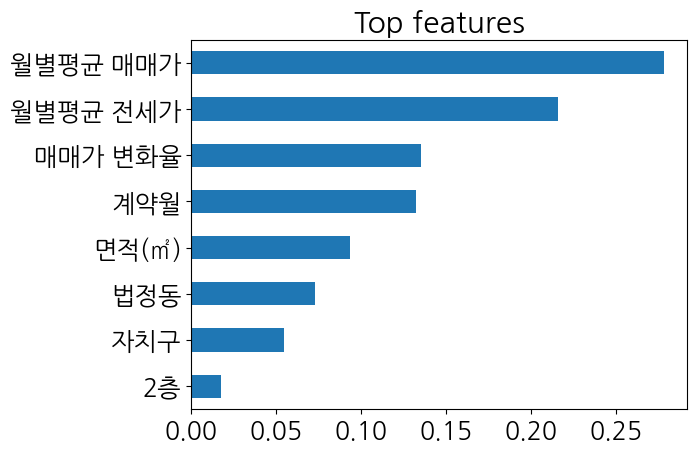

In [22]:
fe = fm.FontEntry(
    fname=r'NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

rf_1 = model_1.named_steps['decisiontreeclassifier']

rf_1.feature_importances_

importances_1 = pd.Series(rf_1.feature_importances_, X_train.columns)

%matplotlib inline

n=20
plt.title(f'Top features')
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
importances_1.sort_values().plot.barh()

<Axes: title={'center': 'Top features'}>

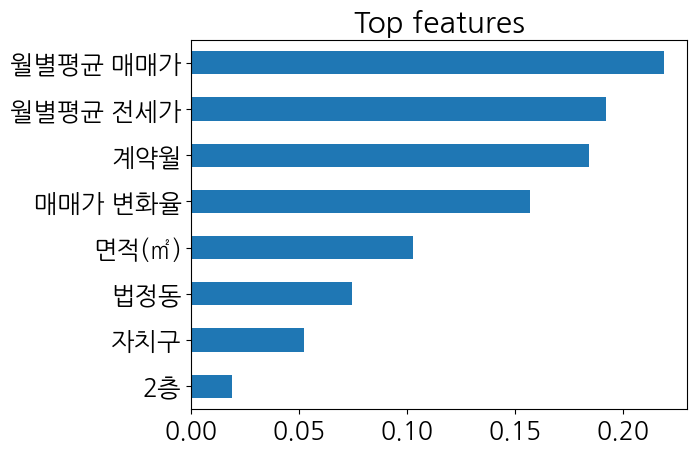

In [23]:
rf_2 = model_2.named_steps['randomforestclassifier']

rf_2.feature_importances_

importances_2 = pd.Series(rf_2.feature_importances_, X_train.columns)

%matplotlib inline

n=20
plt.title(f'Top features')
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
importances_2.sort_values().plot.barh()

<Axes: title={'center': 'Top features'}>

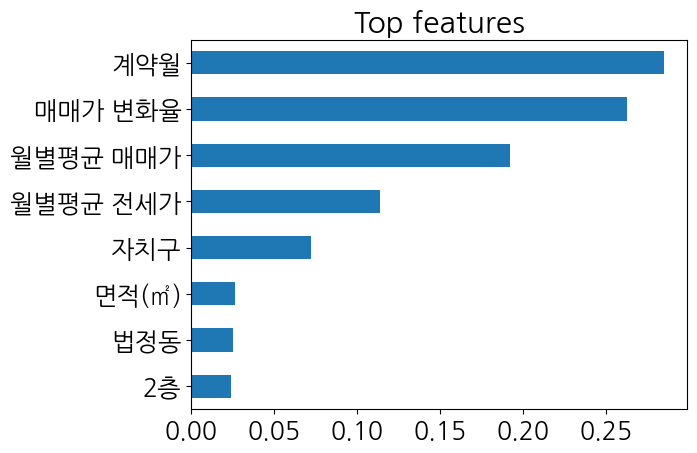

In [24]:
rf_3 = model_3.named_steps['xgbclassifier']

rf_3.feature_importances_

importances_3 = pd.Series(rf_3.feature_importances_, X_train.columns)

%matplotlib inline

n=20
plt.title(f'Top features')
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
importances_3.sort_values().plot.barh()

<Axes: title={'center': 'Top features'}>

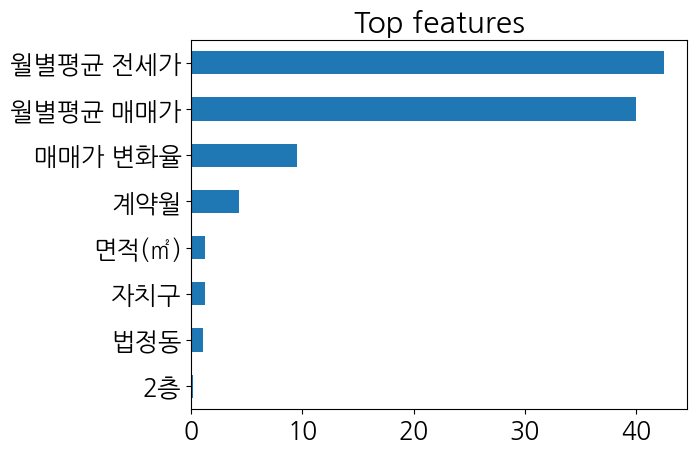

In [25]:
rf_4 = model_4.named_steps['catboostclassifier']

rf_4.feature_importances_

importances_4 = pd.Series(rf_4.feature_importances_, X_train.columns)

%matplotlib inline

n=20
plt.title(f'Top features')
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
importances_4.sort_values().plot.barh()

model = make_pipeline(preprocessor, DecisionTreeClassifier())

criterion = ["gini", "entropy"]
max_depth = [2,4,6,8,10]

parameters = dict(decisiontreeclassifier__criterion=criterion,
                  decisiontreeclassifier__max_depth=max_depth)

clf_GS = GridSearchCV(model, parameters)
clf_GS.fit(X_train, y_train)

print(clf_GS.best_estimator_.get_params()["decisiontreeclassifier"])
CV_Result = cross_val_score(clf_GS, X, y, cv=3, n_jobs=-1, scoring="accuracy")
print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())